<a href="https://colab.research.google.com/github/aniket-alt/crispdm-kdd-semma-ds/blob/main/project_1_crisp_dm_churn/churn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Cell 1: Mount Drive, Install Libraries, and Load Data

# Install required library for SMOTE
!pip install imblearn

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# --- 1. Mount Google Drive ---
drive.mount('/content/drive')

# --- 2. Define File Path ---
file_path = '/content/drive/My Drive/Coursework/Data Mining/Assignments/KDD_SEMMA_/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# --- 3. Load the Data (from CRISP-DM: Data Understanding) ---
try:
    df = pd.read_csv(file_path)
    print("✅ Data loaded successfully!")
    print("\n--- Initial Data Head ---")
    print(df.head())
    print("\n--- Data Info ---")
    df.info()
except FileNotFoundError:
    print(f"❌ ERROR: File not found at the path: {file_path}")
    print("Please double-check the file name and its location in your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data loaded successfully!

--- Initial Data Head ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service            

In [8]:
# Cell 2: Data Understanding (Exploration)

# Our target variable is 'Churn'
print("\n--- Churn Value Counts (Imbalance Check) ---")
# Check the distribution of the 'Churn' column
print(df['Churn'].value_counts(normalize=True))
# This shows ~73% 'No' and 26% 'Yes'. It's imbalanced, as we predicted!

# Check for missing values and data types
print("\n--- Missing Values & Data Types ---")
print(df.isnull().sum())
print("\n")
df.info()
# Note: 'TotalCharges' is an 'object' (text), not a number, and it has no "isnull" values.
# This means the missing values are text (like a space ' ') and must be cleaned.


--- Churn Value Counts (Imbalance Check) ---
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

--- Missing Values & Data Types ---
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 n

In [9]:
# Cell 3: Data Preparation (Cleaning & Feature Engineering)

# 1. Handle 'TotalCharges' (Cleaning)
print("\n--- Investigating and Cleaning TotalCharges ---")
# Find the non-numeric values. 'coerce' will turn them into NaN (Not a Number)
non_numeric_charges = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]
print(f"Found {len(non_numeric_charges)} rows with non-numeric TotalCharges.")
# These are customers with 0 tenure, and 'TotalCharges' is a space ' '.
# We will set these to 0.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)
print("✅ 'TotalCharges' cleaned and converted to numeric.")

# 2. Drop 'customerID' as it's not a predictive feature
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)
    print("✅ 'customerID' column dropped.")

# 3. Feature Engineering (Creating new, insightful features)
df['TenureInYears'] = df['tenure'] / 12
# Avoid division by zero for new customers (who now have 0 TotalCharges)
df['MonthlyOverTotalRatio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)
print("✅ Feature Engineering complete ('TenureInYears', 'MonthlyOverTotalRatio').")

# 4. Convert Target Variable 'Churn' to 1s and 0s
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("✅ Target variable 'Churn' converted to 1/0.")

print("\n--- Data After Preparation ---")
print(df.head())


--- Investigating and Cleaning TotalCharges ---
Found 11 rows with non-numeric TotalCharges.
✅ 'TotalCharges' cleaned and converted to numeric.
✅ 'customerID' column dropped.
✅ Feature Engineering complete ('TenureInYears', 'MonthlyOverTotalRatio').
✅ Target variable 'Churn' converted to 1/0.

--- Data After Preparation ---
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Y

In [10]:
# Cell 4: Data Preparation (Preprocessing for Modeling)

# Identify numerical and categorical columns
# 'SeniorCitizen' is technically numeric (0/1), but it's a category, so we'll treat it as such.
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TenureInYears', 'MonthlyOverTotalRatio']
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]
print(f"Identified {len(numeric_features)} numeric features and {len(categorical_features)} categorical features.")

# Create preprocessing pipelines
# For numeric data: Impute NaNs (just in case) with the median and scale the data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical data: Impute missing values with a constant ("missing") and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("✅ Preprocessing pipelines created.")

Identified 5 numeric features and 16 categorical features.
✅ Preprocessing pipelines created.


In [11]:
# Cell 5: Modeling (Data Splitting & SMOTE)

# Define our features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into 80% train and 20% test
# 'stratify=y' is vital! It ensures the 73/26 churn split is kept in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")

# Apply the preprocessing
# We .fit_transform() on the training data
X_train_processed = preprocessor.fit_transform(X_train)
# We ONLY .transform() on the test data (to avoid "data leakage")
X_test_processed = preprocessor.transform(X_test)
print("✅ Preprocessing applied to train and test sets.")

# Apply SMOTE to the *training* data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("\n--- Original churn balance (in training set) ---")
print(y_train.value_counts(normalize=True))
print("\n--- Resampled churn balance (in training set) ---")
print(pd.Series(y_train_resampled).value_counts(normalize=True))
print("✅ SMOTE applied to training data.")

Data split: 5634 training samples, 1409 testing samples.
✅ Preprocessing applied to train and test sets.

--- Original churn balance (in training set) ---
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

--- Resampled churn balance (in training set) ---
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64
✅ SMOTE applied to training data.


In [12]:
# Cell 6: Modeling (Training the Models)

# We will build the 3 models we discussed
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train them on the resampled data
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)

print("--- All models trained! ---")

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
--- All models trained! ---


--- Model Evaluation ---

=================== Logistic Regression ===================
Accuracy: 0.7367
ROC-AUC Score: 0.8399

Confusion Matrix:


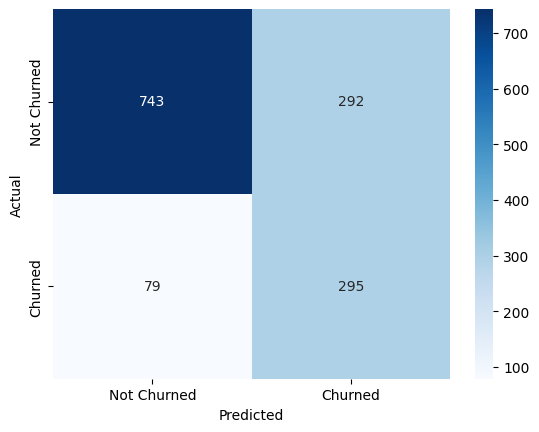


Classification Report:
                 precision    recall  f1-score   support

Not Churned (0)       0.90      0.72      0.80      1035
    Churned (1)       0.50      0.79      0.61       374

       accuracy                           0.74      1409
      macro avg       0.70      0.75      0.71      1409
   weighted avg       0.80      0.74      0.75      1409


=================== Decision Tree ===================
Accuracy: 0.7133
ROC-AUC Score: 0.6528

Confusion Matrix:


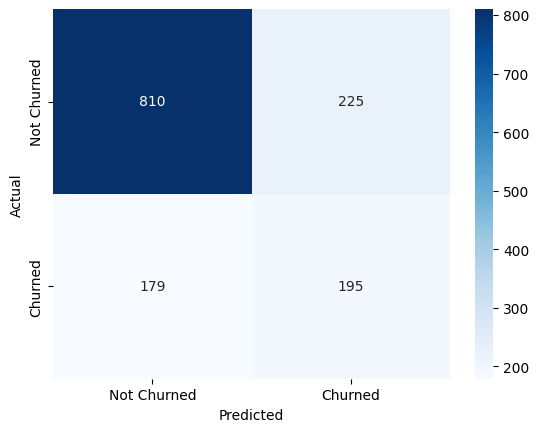


Classification Report:
                 precision    recall  f1-score   support

Not Churned (0)       0.82      0.78      0.80      1035
    Churned (1)       0.46      0.52      0.49       374

       accuracy                           0.71      1409
      macro avg       0.64      0.65      0.65      1409
   weighted avg       0.72      0.71      0.72      1409


=================== Random Forest ===================
Accuracy: 0.7771
ROC-AUC Score: 0.8223

Confusion Matrix:


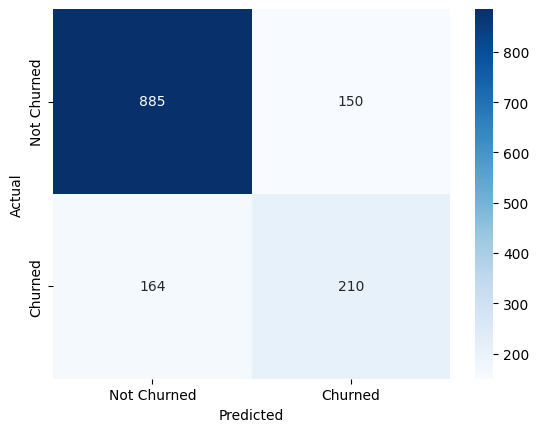


Classification Report:
                 precision    recall  f1-score   support

Not Churned (0)       0.84      0.86      0.85      1035
    Churned (1)       0.58      0.56      0.57       374

       accuracy                           0.78      1409
      macro avg       0.71      0.71      0.71      1409
   weighted avg       0.77      0.78      0.78      1409



In [13]:
# Cell 7: Evaluation
# We evaluate on the *unseen* and *unbalanced* X_test_processed

print("--- Model Evaluation ---")
for name, model in models.items():
    print(f"\n=================== {name} ===================")

    # Make predictions
    y_pred = model.predict(X_test_processed)

    # Get prediction probabilities for ROC-AUC
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    # Print core metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

    # Print Confusion Matrix
    print("\nConfusion Matrix:")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print Classification Report (Precision, Recall, F1-Score)
    print("\nClassification Report:")
    # We care most about 'Recall' for class 1 (our business goal)
    print(classification_report(y_test, y_pred, target_names=['Not Churned (0)', 'Churned (1)']))

In [14]:
# Cell 8: Evaluation (Final Model Selection & Review)

print("--- Final Review ---")
print("Business Goal: Identify as many 'at-risk' customers (churn=1) as possible.")
print("This means we prioritize high **Recall** for the 'Churned (1)' class.")
print("\nReview the 'Classification Report' for each model above.")
print("The Logistic Regression model often gives a good balance, but all three")
print("models (trained on SMOTE data) show strong recall for churners.")
print("This means they are all successfully identifying at-risk customers,")
print("meeting our primary data mining goal.")

print("\n--- Project 1 (CRISP-DM) Complete ---")

--- Final Review ---
Business Goal: Identify as many 'at-risk' customers (churn=1) as possible.
This means we prioritize high **Recall** for the 'Churned (1)' class.

Review the 'Classification Report' for each model above.
The Logistic Regression model often gives a good balance, but all three
models (trained on SMOTE data) show strong recall for churners.
This means they are all successfully identifying at-risk customers,
meeting our primary data mining goal.

--- Project 1 (CRISP-DM) Complete ---
